In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from flask import Flask, request
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

dataset = pd.read_csv('dataset/data.csv')
dataset = dataset.dropna()
dataset.head()

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=12)
test_set.head()

train_datas = train_set.drop("paid_loan", axis=1)
train_labels = train_set["paid_loan"].copy()

test_datas = test_set.drop("paid_loan", axis=1)
test_labels = test_set["paid_loan"].copy()


In [2]:
# pipe line to preprocess data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    #('std_scaler', StandardScaler()),
])
num_attribs = list(train_datas)
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
])
data_prepared = full_pipeline.fit_transform(train_datas)
test_data_prepared = full_pipeline.fit_transform(test_datas)

In [3]:
# train model

param_grid = [
    {'n_estimators': [1,2,3,4,5,6,7,8,9,10], 'max_features': [2,3,4]},
    {'bootstrap': [False], 'n_estimators': [1,2,3,4,5,6,7,8,9,10], 'max_features': [2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)
grid_search.fit(data_prepared, train_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 3, 4],
                          'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [4]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 9}

In [5]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=9)

In [6]:
# forest_reg = RandomForestRegressor(bootstrap=False, max_features=2, n_estimators=10)
forest_reg = grid_search.best_estimator_

In [7]:
forest_reg.fit(data_prepared, train_labels)

RandomForestRegressor(max_features=2, n_estimators=9)

In [8]:
score = forest_reg.score(test_data_prepared, test_labels)
print(score)

0.7770723104056437


In [14]:
my_test = pd.DataFrame({
    "avg_out_call_per_month": 100,
    "avg_in_call_per_month": 100,
    "avg_miss_call_per_month": 20,
    "avg_spend_per_month": 500
}, index=[0])
my_test_prepared = full_pipeline.fit_transform(my_test)
print(my_test_prepared)

[[100. 100.  20. 500.]]


In [15]:
predictions = forest_reg.predict(my_test_prepared)

In [16]:
print(list(predictions))

[0.6666666666666666]


In [12]:
test_set.head()


,avg_out_call_per_month,avg_in_call_per_month,avg_miss_call_per_month,avg_spend_per_month,paid_loan
83,134,93,33,60,0
135,153,262,121,220,0
148,57,46,5,20,1
45,223,23,21,10,0
103,345,23,3,100,1


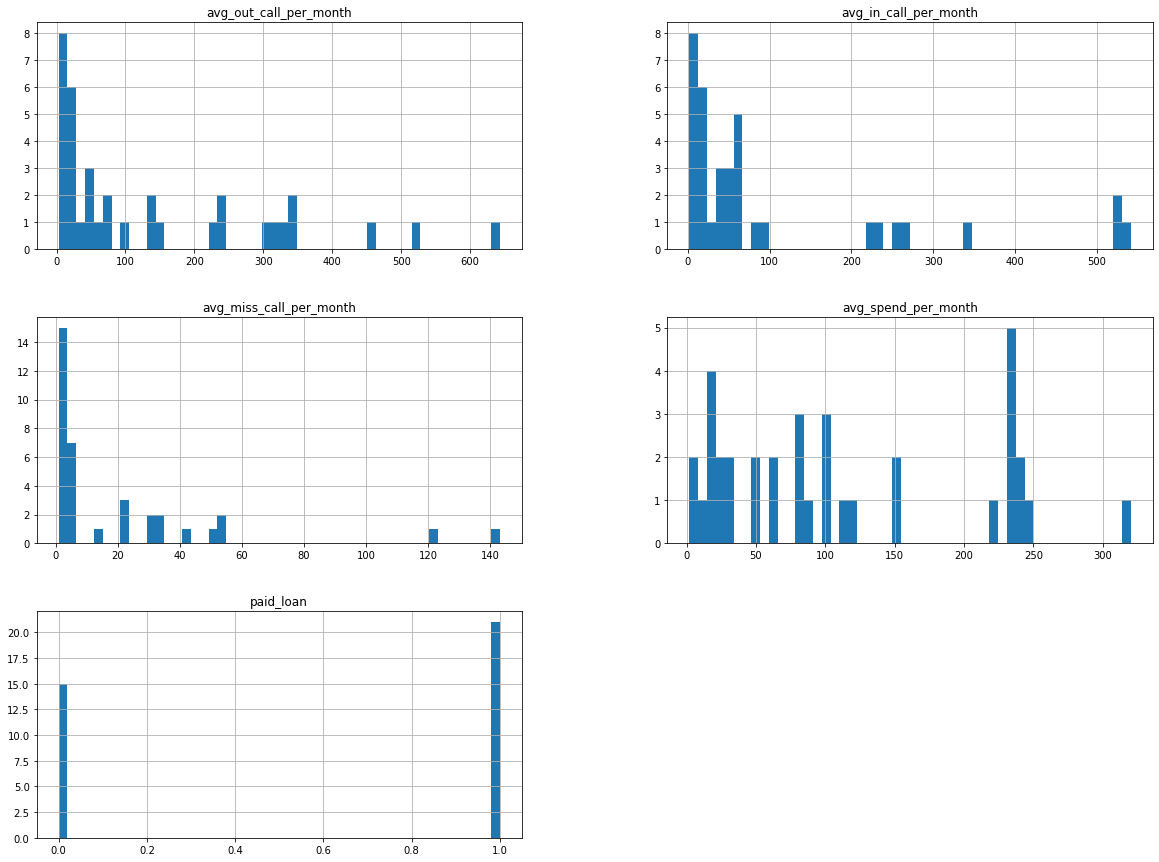

In [13]:
test_set.hist(bins=50, figsize=(20,15))
plt.show()
